# Hands-on Workshop - *Predicting product ratings from reviews*

This workshop is focused on the creation, deployment, monitoring and management of a machine learning model for predicting product ratings from reviews.

### Tom - this isn't completely relevant anymore, will change it before workshop to talk about pretrained model being used etc, so just ignore for now

In this notebook we will be exploring the data, and training the machine learning model itself; in the form of a Tensorflow Keras model. We will then deploy a second Tensorflow model with differing architecture as a Canary model to demonstrate the A/B testing functionality Seldon provides. Then we will begin to add the advanced monitoring and explainability that Seldon Alibi is famed for. 

-----------------------------------
Firstly, we will install and import the relevant packages which we will use throughout the exploration, training, and deployment process. 

In [ ]:
from alibi_detect.cd import KSDrift

### Try another LSTM method

In [28]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from sklearn.utils import class_weight

nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/seldon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("review_data.csv", delimiter=";")

df['review'] = df['review'].astype(str)
df['rating'] = df['rating'].astype(str)

rating_mapping = {
    '1.0': 0,
    '1.5': 1,
    '2.0': 2,
    '2.5': 3,
    '3.0': 4,
    '3.5': 5,
    '4.0': 6, 
    '4.5': 7,
    '5.0': 8
}

df['label'] = df['rating'].apply(lambda x: rating_mapping[x])
df.drop(columns=['product', 'user_id', 'date_created'], axis=1, inplace=True)

df.head()

,rating,review,label
0,5.0,"_product_ provided me with a pretty good, sec...",8
1,4.0,it protects our files and computer and very si...,6
2,5.0,"like most businesses, we are always looking fo...",8
3,3.0,we believed _product_ was a great solution for...,4
4,4.0,i formerly used _product_ and was relieved to ...,6


In [3]:
reviews = []
labels = []

for row in df.iterrows():
    labels.append(row[1]['label'])
    review = row[1]['review']
    for word in STOPWORDS:
        token = ' ' + word + ' '
        review = review.replace(token, ' ')
        review = review.replace(' ', ' ')
    reviews.append(review)
print(len(labels))
print(len(reviews))

50000
50000


In [4]:
# Define hyperparameters

vocab_size = 5000
embedding_dim = 64
max_length = 400
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [5]:
df.value_counts('label')

label
8    31721
6    14017
4     2645
0      763
2      625
7      150
3       27
5       27
1       25
dtype: int64

In [6]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(df['label']),
                                                  y=df['label'])

In [7]:
weights = {}

for index,value in enumerate(class_weights):
    weights[index] = value

In [8]:
weights

{0: 7.2811999417504,
 1: 222.22222222222223,
 2: 8.88888888888889,
 3: 205.76131687242798,
 4: 2.1003990758244067,
 5: 205.76131687242798,
 6: 0.3963441218203293,
 7: 37.03703703703704,
 8: 0.17513809638900274}

In [9]:
train_size = int(len(reviews) * training_portion)

train_articles = reviews[0: train_size]
train_labels = labels[0: train_size]

validation_articles = reviews[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

40000
40000
40000
10000
10000


In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'product': 2,
 'use': 3,
 'i': 4,
 'great': 5,
 'software': 6,
 'easy': 7,
 'it': 8,
 'using': 9,
 'overall': 10}

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[31, 45, 430, 959, 2, 725, 11, 544, 1014, 44, 99, 128, 2, 2087]


In [12]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

21
400
7
400
14
400
10000
(10000, 400)


In [13]:
training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

In [14]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 9 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(9, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 394,889
Trainable params: 394,889
Non-trainable params: 0
_________________________________________________________________


In [102]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8750
    })
})

In [1]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
batch_num = 2048
history = model.fit(encoded_dataset['train']['input_ids'], encoded_dataset['train']['labels'], epochs=num_epochs, batch_size= batch_num, validation_data=(encoded_dataset['val']['input_ids'], encoded_dataset['train']['labels']))

NameError: name 'model' is not defined

## Method using DistilBERT

### First part using pytorch example 
### Second part using tensorflow example

In [62]:
# Install those not pre-installed on Google colab

!pip install datasets
!pip install transformers
!pip install seldon_deploy_sdk
!pip install alibi==0.6.4
!pip install alibi_detect==0.8.1

/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [62]:
import pandas as pd
import numpy as np
import datasets

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from transformers import TFDistilBertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification, create_optimizer
import tensorflow as tf
from tensorflow.data import Dataset

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition
from seldon_deploy_sdk.auth import OIDCAuthenticator

from alibi.explainers import AnchorTabular
from alibi_detect.cd import MMDDrift
from alibi_detect.utils.saving import save_detector, load_detector

In [63]:
pd.set_option('mode.chained_assignment', None)

In [64]:
!gsutil cp gs://kelly-seldon/nlp-ratings/review_data.csv review_data.csv

Copying gs://kelly-seldon/nlp-ratings/review_data.csv...
/ [1 files][ 11.3 MiB/ 11.3 MiB]                                                
Operation completed over 1 objects/11.3 MiB.                                     


In [65]:
df = pd.read_csv("review_data.csv", delimiter=";")

df['review'] = df['review'].astype(str)
df['rating'] = df['rating'].astype(str)

rating_mapping = {
    '1.0': 0,
    '1.5': 1,
    '2.0': 2,
    '2.5': 3,
    '3.0': 4,
    '3.5': 5,
    '4.0': 6, 
    '4.5': 7,
    '5.0': 8
}

df['label'] = df['rating'].apply(lambda x: rating_mapping[x])
df.drop(columns=['product', 'user_id', 'date_created', 'rating'], axis=1, inplace=True)

df.head()

,review,label
0,"_product_ provided me with a pretty good, sec...",8
1,it protects our files and computer and very si...,6
2,"like most businesses, we are always looking fo...",8
3,we believed _product_ was a great solution for...,4
4,i formerly used _product_ and was relieved to ...,6


In [66]:
df_label = pd.get_dummies(df['label'])

In [67]:
df.drop('label', axis=1, inplace=True)

In [68]:
df_whole = df.join(df_label)

In [69]:
df_whole

,review,0,1,2,3,4,5,6,7,8
0,"_product_ provided me with a pretty good, sec...",0,0,0,0,0,0,0,0,1
1,it protects our files and computer and very si...,0,0,0,0,0,0,1,0,0
2,"like most businesses, we are always looking fo...",0,0,0,0,0,0,0,0,1
3,we believed _product_ was a great solution for...,0,0,0,0,1,0,0,0,0
4,i formerly used _product_ and was relieved to ...,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
49995,this is the best form i have even come across ...,0,0,0,0,0,0,0,0,1
49996,"average, not bad but not amazing either. not s...",0,0,0,0,0,0,0,0,1
49997,great,0,0,0,0,0,0,0,0,1
49998,i used act! for years until that became slow a...,0,0,0,0,1,0,0,0,0


### Tom - I'm worried that the labels are so skewed the model won't be able to predict the lower ratings/.5 ratings well

### Tom - have validation split in here too, but don't think I need that if not fine-tuning the model.

In [70]:
train, test = train_test_split(df_whole, test_size=0.3, random_state=42)

train, val = train_test_split(train, test_size=0.25, random_state=42)

In [11]:
test

,review,0,1,2,3,4,5,6,7,8
33553,certainly that it is a big tool to everybody t...,0,0,1,0,0,0,0,0,0
9427,"in base on my experience, a _product_ is a sec...",0,0,0,0,0,0,1,0,0
199,great software for designing,0,0,0,0,0,0,0,0,1
12447,using _product_ allows to optimize industrial ...,0,0,0,0,0,0,0,0,1
39489,solid cloud storage option with the ability to...,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
15168,very good! customer support responded quickly ...,0,0,0,0,0,0,0,0,1
49241,i think that this is a pretty cool software! i...,0,0,0,0,0,0,0,0,1
39317,definitely the standard statistical package in...,0,0,0,0,0,0,0,0,1
42191,have been using it like during my school and c...,0,0,0,0,0,0,0,0,1


In [71]:
train_ds = datasets.Dataset.from_pandas(train, preserve_index=False)
test_ds = datasets.Dataset.from_pandas(test, preserve_index=False)
val_ds = datasets.Dataset.from_pandas(val, preserve_index=False)
comp_ds = datasets.DatasetDict({"train":train_ds,"test":test_ds, "val":val_ds})

In [72]:
comp_ds

DatasetDict({
    train: Dataset({
        features: ['review', '0', '1', '2', '3', '4', '5', '6', '7', '8'],
        num_rows: 26250
    })
    test: Dataset({
        features: ['review', '0', '1', '2', '3', '4', '5', '6', '7', '8'],
        num_rows: 15000
    })
    val: Dataset({
        features: ['review', '0', '1', '2', '3', '4', '5', '6', '7', '8'],
        num_rows: 8750
    })
})

In [73]:
labels = [label for label in comp_ds['train'].features.keys() if label not in ['review']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [74]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_data(examples):
    # take a batch of texts
    text = examples["review"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((1,len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix[0].tolist()

    return encoding

In [75]:
encoded_dataset = comp_ds.map(preprocess_data, remove_columns=comp_ds['train'].column_names)

  0%|          | 0/26250 [00:00<?, ?ex/s]

  0%|          | 0/15000 [00:00<?, ?ex/s]

  0%|          | 0/8750 [00:00<?, ?ex/s]

In [17]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8750
    })
})

In [18]:
example = encoded_dataset['train'][2]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [19]:
example['labels']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [103]:
# encoded_dataset.set_format("tensorflow")

In [20]:
encoded_dataset.set_format("torch")

In [49]:
# tf_train_set = encoded_dataset["train"].to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels"],
#     shuffle=True,
#     batch_size=16,
#     collate_fn=data_collator,
# )

# tf_test_set = encoded_dataset["test"].to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels"],
#     shuffle=False,
#     batch_size=16,
#     collate_fn=data_collator,
# )

# tf_val_set = encoded_dataset["val"].to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels"],
#     shuffle=False,
#     batch_size=16,
#     collate_fn=data_collator,
# )

In [26]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/seldon/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "0",
    "1": "1",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5",
    "6": "6",
    "7": "7",
    "8": "8"
  },
  "initializer_range": 0.02,
  "label2id": {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "q

In [27]:
batch_size = 8
metric_name = "f1"

In [28]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

args = TrainingArguments(
    f"distil-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [29]:
!pip install torch

/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [50]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics

)

In [32]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6851, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.0677, -0.1175,  0.0105,  0.0166, -0.0122, -0.0382,  0.0799, -0.0883,
          0.0854]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [33]:
trainer.train()

/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 26250
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16410


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.165700,0.161395,0.649046,0.791929,0.620229
2,0.153100,0.160734,0.641696,0.783164,0.600114
3,0.134400,0.176416,0.628970,0.783543,0.607543
4,0.105000,0.204808,0.613543,0.778907,0.600914
5,0.089900,0.234696,0.601756,0.772364,0.590629


***** Running Evaluation *****
  Num examples = 8750
  Batch size = 8
Saving model checkpoint to distil-finetuned-sem_eval-english/checkpoint-3282
Configuration saved in distil-finetuned-sem_eval-english/checkpoint-3282/config.json
Model weights saved in distil-finetuned-sem_eval-english/checkpoint-3282/pytorch_model.bin
tokenizer config file saved in distil-finetuned-sem_eval-english/checkpoint-3282/tokenizer_config.json
Special tokens file saved in distil-finetuned-sem_eval-english/checkpoint-3282/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8750
  Batch size = 8
Saving model checkpoint to distil-finetuned-sem_eval-english/checkpoint-6564
Configuration saved in distil-finetuned-sem_eval-english/checkpoint-6564/config.json
Model weights saved in distil-finetuned-sem_eval-english/checkpoint-6564/pytorch_model.bin
tokenizer config file saved in distil-finetuned-sem_eval-english/checkpoint-6564/tokenizer_config.json
Special tokens file saved in distil-finetuned

TrainOutput(global_step=16410, training_loss=0.13285895352825605, metrics={'train_runtime': 22914.8583, 'train_samples_per_second': 5.728, 'train_steps_per_second': 0.716, 'total_flos': 4347129124800000.0, 'train_loss': 0.13285895352825605, 'epoch': 5.0})

### Tom - all of this following now is from following the article https://huggingface.co/docs/transformers/tasks/sequence_classification

In [59]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Create a preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length

In [60]:
def preprocess_function(examples):
    return tokenizer(examples['review'], truncation=True)

In [61]:
test['token_review'] = test['review'].apply(lambda x: preprocess_function(x))

NameError: name 'test' is not defined

In [42]:
comp_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 15000
    })
})

In [45]:
tokenized_revs = comp_ds['train'].map(preprocess_function, batched=True)

  0%|          | 0/35 [00:00<?, ?ba/s]

In [227]:
tokenized_revs

Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 35000
})

In [225]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [47]:
tf_train_set = tokenized_revs["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = tokenized_revs["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

KeyError: "Column train not in the dataset. Current columns in the dataset: ['review', 'label', 'input_ids', 'attention_mask']"

In [19]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_revs['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

### Tom - How does it know to map the labels to the correct labels in the reviews data? Without seeing the training data? There's surely a step missing here that needs adding in if not doing the fine tuning part? Because at the moment is it not unsupervised?

In [20]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=9)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [41]:
prediction = model.predict(test['token_review'][0]['input_ids'])

### Is input_ids the correct thing to be passing here for predictions?

In [46]:
prediction

TFSequenceClassifierOutput(loss=None, logits=array([[ 0.04180664,  0.02156035,  0.01319884, -0.05503405,  0.00553667,
         0.05655766,  0.00432652,  0.00907688,  0.00125564],
       [ 0.00953853, -0.00879546,  0.01612893, -0.05012612,  0.00059584,
         0.03864627,  0.08955497,  0.06449739, -0.11617592]],
      dtype=float32), hidden_states=None, attentions=None)

In [45]:
prediction[0]

array([[ 0.04180664,  0.02156035,  0.01319884, -0.05503405,  0.00553667,
         0.05655766,  0.00432652,  0.00907688,  0.00125564],
       [ 0.00953853, -0.00879546,  0.01612893, -0.05012612,  0.00059584,
         0.03864627,  0.08955497,  0.06449739, -0.11617592]],
      dtype=float32)

### Tom - Can ignore this - another example I found online of fine-tuning DistilBert

In [26]:
# model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)

# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_39', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [28]:
# model.fit(tf_train_set.shuffle(1000).batch(16), epochs=3, batch_size=16,
#           validation_data=tf_test_set.shuffle(1000).batch(16))

Epoch 1/3


TypeError: in user code:

    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/modeling_tf_utils.py", line 996, in train_step
        y_pred = self(x, training=True)
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "tf_distil_bert_for_sequence_classification_1" (type TFDistilBertForSequenceClassification).
    
    in user code:
    
        File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/modeling_tf_utils.py", line 730, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 742, in call  *
            distilbert_output = self.distilbert(
        File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "distilbert" (type TFDistilBertMainLayer).
        
        in user code:
        
            File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/modeling_tf_utils.py", line 730, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 400, in call  *
                embedding_output = self.embeddings(input_ids, inputs_embeds=inputs_embeds)  # (bs, seq_length, dim)
            File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
        
            TypeError: Exception encountered when calling layer "embeddings" (type TFEmbeddings).
            
            in user code:
            
                File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 122, in call  *
                    final_embeddings = self.LayerNorm(inputs=final_embeddings)
                File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
            
                TypeError: Exception encountered when calling layer "LayerNorm" (type LayerNormalization).
                
                Failed to convert elements of [1, 1, None, 1] to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
                
                Call arguments received:
                  • inputs=tf.Tensor(shape=(None, 16, None, 768), dtype=float32)
            
            
            Call arguments received:
              • input_ids=tf.Tensor(shape=(None, 16, None), dtype=int64)
              • position_ids=None
              • inputs_embeds=None
              • training=True
        
        
        Call arguments received:
          • self=tf.Tensor(shape=(None, 16, None), dtype=int64)
          • input_ids=None
          • attention_mask=tf.Tensor(shape=(None, 16, None), dtype=int64)
          • head_mask=None
          • inputs_embeds=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received:
      • self={'input_ids': 'tf.Tensor(shape=(None, 16, None), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(None, 16, None), dtype=int64)', 'labels': 'tf.Tensor(shape=(None, 16), dtype=int64)'}
      • input_ids=None
      • attention_mask=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True


### Tom - Need to add accuracy metric in here too, but got error about using internal loss function meaning you can't specify additional metrics. At the moment is it unsupervised because it's using the pretrained labels? and this is why we don't see accuracy?

In [17]:
model.compile(
    optimizer=optimizer
)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Tom - tf_test_set - the reviews have been tokenised. Does the tokeniser need embedding in the model? Otherwise a preprocesser will be needed in order to pass raw text to the model?

In [23]:
loss = model.evaluate(tf_test_set)

703/938 [=====================>........] - ETA: 4:02 - loss: 2.1695

KeyboardInterrupt: 

## Tom - from here down not used anymore - this was messing to build a custom model

In [445]:
weights

{0: 0.17513809638900274,
 1: 0.3963441218203293,
 2: 2.1003990758244067,
 3: 7.2811999417504,
 4: 8.88888888888889,
 5: 37.03703703703704,
 6: 205.76131687242798,
 7: 205.76131687242798,
 8: 222.22222222222223}

Convert dataset into tensorflow dataset.

In [446]:
ds_train = Dataset.from_tensor_slices((train['review'].values, train['rating'].values))
ds_test = Dataset.from_tensor_slices((test['review'].values, test['rating'].values))
ds_val = Dataset.from_tensor_slices((val['review'].values, val['rating'].values))

Covert categorical target variable to numeric variable.

In [37]:
# if using can pop this in a function, just experimenting

ct0, ct1, ct2, ct3, ct4, ct5, ct6, ct7, ct8 = np.bincount(y_train)
total = len(df)

weight_for_0 = (1 / ct0) * (total / 9.0)
weight_for_1 = (1 / ct1) * (total / 9.0)
weight_for_2 = (1 / ct2) * (total / 9.0)
weight_for_3 = (1 / ct3) * (total / 9.0)
weight_for_4 = (1 / ct4) * (total / 9.0)
weight_for_5 = (1 / ct5) * (total / 9.0)
weight_for_6 = (1 / ct6) * (total / 9.0)
weight_for_7 = (1 / ct7) * (total / 9.0)
weight_for_8 = (1 / ct8) * (total / 9.0)

class_weights = {
    0: weight_for_0, 
    1: weight_for_1, 
    2: weight_for_2, 
    3: weight_for_3,
    4: weight_for_4,
    5: weight_for_5,
    6: weight_for_6,
    7: weight_for_7,
    8: weight_for_8
}

NameError: name 'y_train' is not defined

In [302]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

In [303]:
int_vectorize_layer.adapt(X_train)

In [304]:
def int_vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return int_vectorize_layer(text), label

In [311]:
y_train = to_categorical(y_train)

In [312]:
int_train_ds = int_vectorize_text(X_train, y_train)
int_val_ds = int_vectorize_text(X_val, y_val)
int_test_ds = int_vectorize_text(X_test, y_test)

In [313]:
int_train_ds

(<tf.Tensor: shape=(33750, 150), dtype=int64, numpy=
 array([[  6,  83,  35, ...,   0,   0,   0],
        [733,   3,  31, ...,   0,   0,   0],
        [ 40,   4,  45, ...,   0,   0,   0],
        ...,
        [  6,  18,  19, ...,   0,   0,   0],
        [ 40,  57,  11, ...,   0,   0,   0],
        [  6, 183,   5, ...,   0,   0,   0]])>,
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32))

**Embedding layer**

Input shape:
2D tensor with shape: (batch_size, input_length).

Output shape:
3D tensor with shape: (batch_size, input_length, output_dim).

*Do I have this right at the moment? I have input length as the vocab size... should output_dim be 9? What should it be?*

input_length = Integer. Size of the vocabulary, i.e. maximum integer index + 1.

output_dim = Integer. Dimension of the dense embedding.


**Conv1D layer**

Should it not be 16 here?... filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

Should it not be 5 here?... kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.

Do I need an input_shape argument? I don't know if I do as it's not the first layer? Embedding is the first layer?


In [327]:
test_shape = int_train_ds[0].reshape(len(int_train_ds[0]), int_train_ds[0].shape[1],1)

In [326]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [336]:
# Input
from tensorflow.keras.layers import Input

in_shape = (test_shape.shape[1],1)
inputs = Input(shape=(in_shape), name='inputs_cnn')

In [337]:
inputs

<KerasTensor: shape=(None, 150, 1) dtype=float32 (created by layer 'inputs_cnn')>

In [323]:
int_train_ds[0]

<tf.Tensor: shape=(33750, 150), dtype=int64, numpy=
array([[  6,  83,  35, ...,   0,   0,   0],
       [733,   3,  31, ...,   0,   0,   0],
       [ 40,   4,  45, ...,   0,   0,   0],
       ...,
       [  6,  18,  19, ...,   0,   0,   0],
       [ 40,  57,  11, ...,   0,   0,   0],
       [  6, 183,   5, ...,   0,   0,   0]])>

In [355]:
def create_model(vocab_size, num_labels, input_shape):
    model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 1024, mask_zero=True, input_shape=input_shape),
      layers.Conv1D(1024, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
    ])
    return model

In [356]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=9, input_shape=in_shape)
int_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(
    inputs, 
    int_train_ds[1], 
#     validation_data=(int_val_ds[0], int_val_ds[1]), 
    epochs=15,
    class_weight=class_weights
)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_34. Consider increasing the input size. Received input shape [None, 150, 1, 1024] which would produce output shape with a zero or negative value in a dimension.

In [274]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [275]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

In [276]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend();

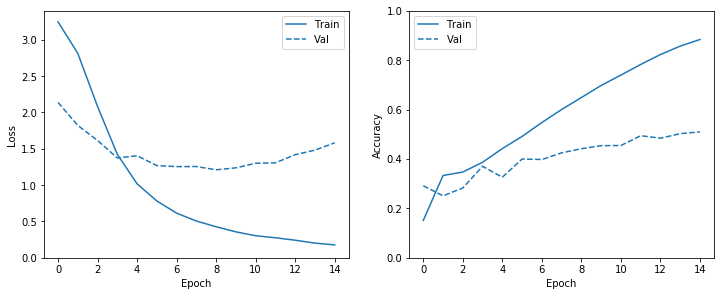

In [286]:
plot_metrics(history)

In [287]:
int_loss, int_accuracy = int_model.evaluate(int_test_ds[0], int_test_ds[1])

print("Int model accuracy: {:2.2%}".format(int_accuracy))

157/157 [==============================] - 0s 1ms/step - loss: 1.5388 - accuracy: 0.5240
Int model accuracy: 52.40%


In [288]:
predictions = int_model.predict(int_test_ds[0])
print(predictions[:1])

[[-12.551326   -14.205595   -10.307593    -6.996902    -6.236613
  -11.317929    14.247541     0.38065982  15.718541  ]]


In [289]:
print(predictions)

[[-12.551326   -14.205595   -10.307593   ...  14.247541     0.38065982
   15.718541  ]
 [ -2.5539522  -11.087661     2.168796   ...   0.59642243  -8.97046
    5.491527  ]
 [-14.290668   -13.789915    -4.7460256  ...  11.998764     1.4773175
   13.5251255 ]
 ...
 [-16.912428   -18.866726   -10.535642   ...   7.2865367   -3.2117934
   10.618746  ]
 [ -7.1668673  -10.601623    -6.650805   ...  -4.0072656   -5.804961
   -0.5142288 ]
 [ -3.5702062   -6.9096284   -2.2240076  ...  -1.6571041   -4.138695
    0.28596228]]


In [290]:
test_re = int_test_ds[1].reset_index(drop=True)

In [291]:
test_val_list = []
pred_val_list = []

for i in range(0,len(test_re)):
    test_val = test_re[i]
    test_val_list.append(test_val)
    pred_val = list(predictions[i]).index(predictions[i].max())
    pred_val_list.append(pred_val)

In [292]:
df_results = pd.DataFrame(
        {'Test_val':test_val_list,
            'Pred_val':pred_val_list}

)

In [293]:
df_results

,Test_val,Pred_val
0,2,8
1,6,8
2,8,8
3,8,8
4,8,6
...,...,...
4995,8,8
4996,8,6
4997,8,8
4998,6,8


In [294]:
df_results['match']='False'
df_results.loc[df_results['Test_val']==df_results['Pred_val'],'match'] = 'True'

In [295]:
df_group = df_results.groupby(['Test_val','match']).count()

In [296]:
df_results['Pred_val'].value_counts(normalize=True)

8    0.6066
6    0.3024
4    0.0510
0    0.0196
2    0.0166
7    0.0024
3    0.0008
5    0.0004
1    0.0002
Name: Pred_val, dtype: float64

In [298]:
df_group

Pred_val
Test_val match          
0        False        55
         True         26
1        False         1
2        False        46
         True          5
4        False       246
         True         37
5        False         1
         True          1
6        False       901
         True        472
7        False        14
         True          1
8        False      1116
         True       2078

## Model Deployment

You can now deploy your model to the dedicated Seldon Deploy cluster which we have configured for this workshop. To do so you will interact with the Seldon Deploy SDK and deploy your model using that.

First, setting up the configuration and authentication required to access the cluster. Make sure to fill in the SD_IP variable to be the same as the cluster you are using.

In [5]:
# To do - speak to Tom around which cluster we will be using for the workshop/ask Alejandro for 
# a cluster to be manually spun up if needed

SD_IP = ""

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now you have configured the IP correctly as well as setup your authentication function you can describe the deployment you would like to create. 

You will need to fill in the `DEPLOYMENT_NAME`. The `NAMESPACE` and `MODEL_LOCATION`, along with the rest of the deployment description has been templated for you. 

## To do - check with Tom - is this true for Tensorflow? Are models always saved as a folder with assets, metadata, model.pb etc? Or can you just save the model as model.pb in this case?

For the `MODEL_LOCATION`, it is worth nothing that you will not specify the path all the way up to `model.pb`, but instead the path should be to the model folder for your transformer model i.e. `MODEL_LOCATION` should be `gs://kelly-seldon/nlp-ratings/saved-model`

In [ ]:
DEPLOYMENT_NAME = 
NAMESPACE = "seldon-gitops"
MODEL_LOCATION = f"gs://gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}"

PREPACKAGED_SERVER = "TENSORFLOW_SERVER"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

You can now invoke the SeldonDeploymentsApi and create a new Seldon Deployment.

Time for you to get your hands dirty. You will use the Seldon Deploy SDK to create a new Seldon deployment. You can find the reference documentation [here](https://github.com/SeldonIO/seldon-deploy-sdk/blob/master/python/README.md).

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

You can access the Seldon Deploy cluster and view your freshly created deployment here:

### To do - add cluster IP in here when cluster is decided on

* URL: http:///seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

## Adding a Prediction Schema and Metadata

Seldon Deploy has a model catalog where all deployed models are automatically registered. The model catalog can store custom metadata as well as prediction schemas for your models.

Metadata promotes lineage from across different machine learning systems, aids knowledge transfer between teams, and allows for faster deployment. Meanwhile, prediction schemas allow Seldon Deploy to automatically profile tabular data into histograms, allowing for filtering on features to explore trends.

In order to effectively construct a prediction schema Seldon has the ML Prediction Schema project. 

In [1]:
prediction_schema = {
    "requests": [
        {
            "name": "Product Review",
            "type": "TEXT",
        }
    ],
    "responses": [
        {
            "name": "Rating",
            "type": "CATEGORICAL",
            "data_type": "INT",
            "n_categories": 9,
            "category_map": {
            "0": "1.0",
            "1": "1.5",
            "2": "2.0",
            "3": "2.5",
            "4": "3.0",
            "5": "3.5",
            "6": "4.0",
            "7": "4.5",
            "8": "5.0"
        }
        }
    ]
}

You then add the prediction schema to the wider model catalog metadata. This includes information such as the model storage location, the name, who authored the model etc. The metadata tags and metrics which can be associated with a model are freeform and can therefore be determined based upon the use case which is being developed. 

In [4]:
# To do if time - add accuracy as a metric in here once have a working model

model_catalog_metadata = {
      "URI": MODEL_LOCATION,
      "name": f"{DEPLOYMENT_NAME}-model",
      "version": "v1.0",
      "artifactType": "Tensorflow",
      "taskType": "Product review rating classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "project": "default",
      "prediction_schema": prediction_schema
    }

# model_catalog_metadata

NameError: name 'MODEL_LOCATION' is not defined

Next, using the metadata API you can add this to the model which you have just created in Seldon.

In [ ]:
metadata_api = ModelMetadataServiceApi(auth())
metadata_api.model_metadata_service_update_model_metadata(model_catalog_metadata)

You can then list the metadata via the API, or view it in the UI, to confirm that it has been successfully added to the model. 

In [ ]:
metadata_response = metadata_api.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
metadata_response

## Make Predictions

Now you can have a go at sending some requests to your model using the 'Predict' tab in the UI. 

An example of a good review that we would expect to correspond to a higher rating.

```
{
    "data": {
        "names": ["Review"],
        "ndarray": ["_product_ is excellent! I love it, it's great!"]
    }
}
```

And an example of a negative review that we would expect to correspond to a lower rating.

```
{
    "data": {
        "names": ["Review"],
        "ndarray": ["_product_ was terrible, I would not use it again, it was awful!"]
    }
}
```

## Drift Detection

Although powerful, modern machine learning models can be sensitive. Seemingly subtle changes in a data distribution can destroy the performance of otherwise state-of-the art models, which can be especially problematic when ML models are deployed in production. Typically, ML models are tested on held out data in order to estimate their future performance. Crucially, this assumes that the process underlying the input data `X` and output data `Y` remains constant.

Drift can be classified into the following types:
* **Covariate drift**: Also referred to as input drift, this occurs when the distribution of the input data has shifted `P(X) != Pref(X)`, whilst `P(Y|X) = Pref(Y|X)`. This may result in the model giving unreliable predictions.

* **Prior drift**: Also referred to as label drift, this occurs when the distribution of the outputs has shifted `P(Y) != Pref(Y)`, whilst `P(X|Y) = Pref(X|Y)`. This can affect the model’s decision boundary, as well as the model’s performance metrics.

* **Concept drift**: This occurs when the process generating `Y` from `X` has changed, such that `P(Y|X) != Pref(Y|X)`. It is possible that the model might no longer give a suitable approximation of the true process.

-----------------

In this instance we will train a Kolmgorov-Smirnov drift detector to pick up on covariate drift. The KS Drift detector applies a two-sample KS test to compare the distance between the new probability distribution and the reference distribution. 

This is done on a feature by feature basis and the results are then aggregated using a correction, i.e. Bonferroni, to determine whether drift has occurred overall within the sample. 

We will use the training set as our reference distribution. Creating our drift detector is then as simple as writing a single line of code:

In [78]:
dd_array = np.asarray(encoded_dataset['train']['input_ids'][:5000])

In [82]:
dd = KSDrift(dd_array, p_val=.05, correction='bonferroni')

In [88]:
preds = dd.predict(dd_array)
labels = ["No", "Yes"]

print(f'Drift? {labels[preds["data"]["is_drift"]]}')

Drift? No


In [89]:
preds = dd.predict(
    np.asarray(encoded_dataset['test']['input_ids'][6700:6800]), 
    return_p_val=True, 
    return_distance=True)
preds

{'data': {'is_drift': 0,
  'distance': array([0.    , 0.0736, 0.0778, 0.0618, 0.078 , 0.0686, 0.1028, 0.061 ,
         0.1342, 0.128 , 0.0932, 0.1122, 0.1264, 0.1026, 0.0536, 0.0752,
         0.1442, 0.1262, 0.104 , 0.0808, 0.0604, 0.101 , 0.0792, 0.1144,
         0.0878, 0.093 , 0.0936, 0.1054, 0.1232, 0.1152, 0.1056, 0.158 ,
         0.1144, 0.1206, 0.1206, 0.0956, 0.0736, 0.0842, 0.0758, 0.0686,
         0.078 , 0.069 , 0.082 , 0.0672, 0.0502, 0.0584, 0.085 , 0.0592,
         0.0702, 0.067 , 0.069 , 0.0512, 0.0548, 0.059 , 0.0584, 0.0746,
         0.054 , 0.059 , 0.0678, 0.058 , 0.0454, 0.0544, 0.0496, 0.055 ,
         0.046 , 0.0322, 0.0328, 0.044 , 0.0352, 0.0224, 0.0334, 0.027 ,
         0.028 , 0.0508, 0.0172, 0.0264, 0.0436, 0.0216, 0.0338, 0.0144,
         0.0254, 0.0364, 0.064 , 0.0314, 0.0406, 0.0226, 0.0318, 0.014 ,
         0.0244, 0.0322, 0.0404, 0.0238, 0.0384, 0.0358, 0.036 , 0.022 ,
         0.0344, 0.031 , 0.0192, 0.032 , 0.0296, 0.02  , 0.0214, 0.0172,
         0.013

In [84]:
save_detector(dd, "reviews-drift-detector")

In [87]:
## Will add this earlier when saving the model etc

YOUR_NAME = "kelly-spry"

In [86]:
!gsutil cp -r reviews-drift-detector gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}/reviews-drift-detector

Copying file://reviews-drift-detector/KSDrift.dill [Content-Type=application/octet-stream]...
Copying file://reviews-drift-detector/meta.dill [Content-Type=application/octet-stream]...
| [2 files][  4.9 MiB/  4.9 MiB]                                                
Operation completed over 2 objects/4.9 MiB.                                      


To deploy the drift detector you will use Seldon Deploy's user interface. Simply navigate to your deployment, and select the "Create" button for your drift detector.

This will bring up a form. Add your detector name, the URI which will be gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}/reviews-drift-detector, and set a batch size of 10.

The batch size configuration sets how many data points have to be sent to the endpoint before drift is calculated.

## Explainability